In [1]:
# Importing nessecary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = (15,10)

## Loading Data 

In [2]:
# Data is written into csv files, using pandas these can be saved into a dataframe

Part1_Uncooled = pd.read_csv(r'Uncooled_1_Data.csv')
del Part1_Uncooled['Unnamed: 3']

Part1_Cooled = pd.read_csv(r'Cooled_1_Data.csv')
del Part1_Cooled['Unnamed: 3']

Part2_Cooled = pd.read_csv(r'Cooled_2_Data.csv')
del Part2_Cooled['Unnamed: 3']
Part1_Cooled

,Va(V),Vs(mV),Vp(mV)
0,0.00,2.5,3.1
1,0.10,4.7,4.4
2,0.20,8.0,5.6
3,0.30,11.8,6.9
4,0.40,15.5,8.1
...,...,...,...
74,12.00,1200.0,398.0
75,12.25,1231.0,410.0
76,12.50,1262.0,423.0
77,12.75,1292.0,435.0


In [3]:
# Converting the different panda columns to numpy arrays for futher and easier analysis
uncooled1_Va = Part1_Uncooled['Va(V)'].to_numpy()
uncooled1_Vs = Part1_Uncooled['Vs(mV)'].to_numpy()
uncooled1_Vp = Part1_Uncooled['Vp(mV)'].to_numpy()

cooled1_Va = Part1_Cooled['Va(V)'].to_numpy()
cooled1_Vs = Part1_Cooled['Vs(mV)'].to_numpy()
cooled1_Vp = Part1_Cooled['Vp(mV)'].to_numpy()

cooled2_Va = Part2_Cooled['Va(V)'].to_numpy()
cooled2_Vs = Part2_Cooled['Vs(mV)'].to_numpy()
cooled2_Vp = Part2_Cooled['Vp(mV)'].to_numpy()

len(uncooled1_Va)

79

### Analysis - Investigation 1

In [4]:
# Creating a function to calculate the current in Amps - requires a millivolt input
def ohmsLaw(milivoltages,resistance): 
    volts = milivoltages/1000
    return (volts/resistance)

In [5]:
# Shiled and plate voltages conerted to currents and saved to arrays
uncooled_Is = ohmsLaw(uncooled1_Vs,100)
uncooled_Ip = ohmsLaw(uncooled1_Vp,10000)

cooled1_Is = ohmsLaw(cooled1_Vs,100)
cooled1_Ip = ohmsLaw(cooled1_Vp,10000)

cooled2_Is = ohmsLaw(cooled2_Vs,100)
cooled2_Ip = ohmsLaw(cooled2_Vp,10000)

In [6]:
# Data to go into tables

Part1_Uncooled['Is(mA)'] = (uncooled_Is*1000).tolist()
Part1_Uncooled['Ip(microA)'] = (uncooled_Ip*1000000).tolist()

with open('part1Uncooled','w') as tf :
    tf.write(Part1_Uncooled.to_latex())

Part1_Cooled['Is(mA)'] = (cooled1_Is*1000).tolist()
Part1_Cooled['Ip(microA)'] = (cooled1_Ip*1000000).tolist()

with open('part1Cooled','w') as rf :
    rf.write(Part1_Cooled.to_latex())

Part2_Cooled['Is(microA)'] = (cooled2_Is*1000000).tolist()
Part2_Cooled['Ip(microA)'] = (cooled2_Ip*1000000).tolist()

with open('part2Cooled','w') as qf :
    qf.write(Part2_Cooled.to_latex())
 

In [7]:
# Calculating errors 

# The measurements are limited by the multimeter with a restriction of 0.1mV, assuming error on resistance is zero

def errorOnCurrent(voltErr,resistance):
    part1 = voltErr**2
    part2 = (1/resistance)**2
    return np.sqrt(part1*part2)

shieldError = errorOnCurrent(1e-4,100)
plateError = errorOnCurrent(1e-4,10000)

def sqrtVoltError(vp,vs,dvs):
    part1 = dvs**2
    part2 =((-1)/(2*np.sqrt(vp-vs)))**2
    return np.sqrt(np.abs(part1*part2))

simpleElectronMomentumErr = sqrtVoltError(uncooled1_Va,(uncooled1_Vs/1000),0.0001)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


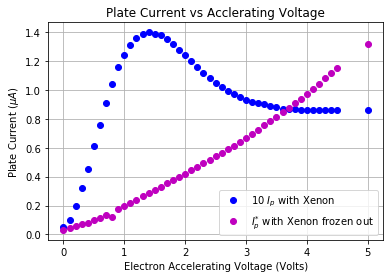

In [8]:
# Creating the first plot - Plate current vs accelerating voltage. (Only first 47 points used)

plt.plot(uncooled1_Va[:47],uncooled_Ip[:47]*1e6,'bo',label=r'10 $I_p$ with Xenon')
plt.plot(cooled1_Va[:47],cooled1_Ip[:47]*1e5,'mo',label=r'$I_{p}^{*}$ with Xenon frozen out')
#plt.errorbar(uncooled1_Va[:47],cooled1_Ip[:47],yerr=plateError,fmt='.', label='Data Uncertainty')
#plt.errorbar(cooled1_Va[:47],cooled1_Ip[:47],yerr=plateError, fmt='.', label='Data Uncertainty')
plt.xlabel('Electron Accelerating Voltage (Volts)')
plt.ylabel(r'Plate Current ($\mu A$)')
plt.title('Plate Current vs Acclerating Voltage')
plt.grid(True)
plt.legend();
#plt.savefig('IpVsVa',format='eps')


In [9]:
# Creating functions to calculate the scattering probability and the associated error

def scatteringProbability(Ip,Ip_cooled,Is,Is_cooled): # Function to calculate the probability of scattering
    numerator = Ip*Is_cooled
    denominator = Is*Ip_cooled
    return 1- (numerator/denominator)

# Error funciton uses the propagation of errors formula treating both cooled and uncooled shield and plate voltages as differntiable variables
def findTheError(uncooledPlate, uncooledPlateErr, uncooledShield, uncooledShieldErr, cooledPlate, cooledPlateErr, cooledShield, cooledShieldErr):
    part1 = uncooledPlateErr**2
    part2 = ((-1*cooledShield)/(uncooledShield*cooledPlate))**2
    part3 = cooledShieldErr**2
    part4 = ((-uncooledPlate)/(uncooledShield*cooledPlate))**2
    part5 = uncooledShieldErr**2
    part6 = ((uncooledPlate*cooledShield)/(((uncooledShield)**2)*cooledPlate))**2
    part7 = cooledPlateErr**2
    part8 = (uncooledPlate*cooledShield)/(uncooledShield*(cooledPlate**2))
    return np.sqrt((part1*part2) + (part3*part4) + (part5*part6) + (part7*part8))

scatterProbErr = findTheError(uncooled_Ip, plateError, uncooled_Is, shieldError, cooled1_Ip, plateError, cooled1_Is, shieldError)

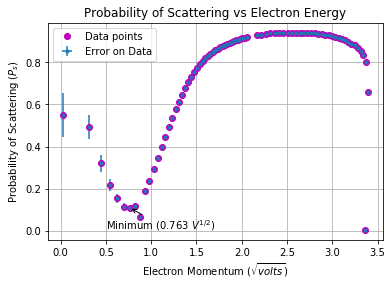

In [10]:
# Plotting the probability of scattering vs the electron energy with errorbars 

scatterProb = scatteringProbability(uncooled_Ip,cooled1_Ip,uncooled_Is,cooled1_Is) 
electronMomentum = np.sqrt(np.abs(uncooled1_Va - (uncooled1_Vs/1000)))

plt.plot(electronMomentum,np.abs(scatterProb),'mo', label = 'Data points')
plt.errorbar(electronMomentum,np.abs(scatterProb), xerr = simpleElectronMomentumErr,yerr = scatterProbErr, fmt = '.',label='Error on Data')
plt.xlabel(r'Electron Momentum ($\sqrt{volts}$)')
plt.ylabel(r'Probability of Scattering ($P_s$)')
plt.title('Probability of Scattering vs Electron Energy')
plt.grid(True)
plt.legend()
plt.annotate(r'Minimum (0.763 $V^{1/2}$)', (electronMomentum[6],scatterProb[6]),(0.5,0.01),arrowprops={'arrowstyle':'->'});
#plt.savefig('scatterProbFinal',format='eps')

In [11]:
simpleElectronMomentumErr[6]

6.556848434495742e-05

In [12]:
# Creating functions to calculate the free path and uncertainties for the mean free path and probability of colllision

def freePath(Ps, l): 
    numerator = -l
    denominator = np.log(1-Ps)
    return (numerator/denominator)

meanFreePath = freePath(scatterProb,0.7)

def freePathErr(scatterProb,PsErr): # uses propagation of errors formula
    part1 = PsErr**2
    part2 = ((-0.007)/(np.log(1-scatterProb)*(1-scatterProb)))**2
    return np.sqrt(part1*part2)

meanFreePathError = freePathErr(scatterProb,scatterProbErr)

def collisionProbErr(meanPathErr,meanPath,pressure): #also uses propagation of errors formula
    part1 = meanPathErr**2
    part2 = ((-pressure)/(meanPath**2))**2
    return np.sqrt(part1*part2)
collisionProbError = collisionProbErr(meanFreePathError,meanFreePath,1e-3)

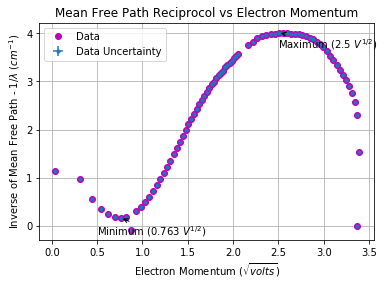

In [13]:
plt.plot(electronMomentum,1/meanFreePath,'mo',label='Data')
plt.errorbar(electronMomentum, 1/meanFreePath,xerr = simpleElectronMomentumErr, yerr=meanFreePathError,fmt='.',label='Data Uncertainty')
plt.xlabel(r'Electron Momentum ($\sqrt{volts}$)')
plt.ylabel(r'Inverse of Mean Free Path - $1/\lambda$ ($cm^{-1}$)')
plt.title('Mean Free Path Reciprocol vs Electron Momentum')
plt.grid(True)
plt.legend()
plt.annotate(r'Minimum (0.763 $V^{1/2}$)', (electronMomentum[6],(1/meanFreePath)[6]),(0.5,-0.2),arrowprops={'arrowstyle':'->'})
plt.annotate(r'Maximum (2.5 $V^{1/2}$)', (electronMomentum[-26],(1/meanFreePath)[-26]),(2.5,3.70),arrowprops={'arrowstyle':'->'});
#plt.savefig('InverseMfpFinal',format='eps')

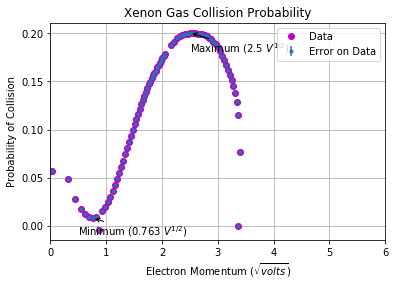

In [14]:
# Plotting the probability of collision against the electron momentum along with associated errors

collisionProb = (0.05)/meanFreePath # ******check this value for pressure *****

plt.plot(electronMomentum,collisionProb,'mo',label='Data')
plt.errorbar(electronMomentum,collisionProb, yerr = collisionProbError, fmt = '.',label='Error on Data')
plt.xlim([0,6])
plt.grid(True)
plt.xlabel(r'Electron Momentum ($\sqrt{volts}$)')
plt.ylabel('Probability of Collision')
plt.title('Xenon Gas Collision Probability')
plt.legend()
plt.annotate(r'Minimum (0.763 $V^{1/2}$)', (electronMomentum[6],collisionProb[6]),(0.5,-.01),arrowprops={'arrowstyle':'->'})
plt.annotate(r'Maximum (2.5 $V^{1/2}$)', (electronMomentum[-26],collisionProb[-26]),(2.5,0.18),arrowprops={'arrowstyle':'->'});
#plt.savefig('collisoinProbFinal',format='eps');

In [15]:
collisionProb[-26],simpleElectronMomentumErr[-26]

(0.20066522240776863, 1.9952172111690556e-05)

### Analysis - Investigation 2

In [16]:
# Generating required data for plot
yAxis = (cooled2_Is[:35]) # only use first 35 points to avoid multiple zeros
xAxis = (-1*cooled2_Va + (cooled2_Vs/1000))[:35] # same for x axis. This is the retarding potential

In [17]:
newYAxis= np.delete(yAxis,[29,30,31,32,33,34]) # Taking only the least negative relative voltage due to uncertainty on equipment
newXAxis = np.delete(xAxis,[i for i in range(29,35)]) # Same here

def currentLogErr(dI,I): # finding error of log(I_s ^*)
    part1 = dI**2
    part2 = (1/(I*np.log(10)))**2
    return np.sqrt(part1*part2)
cooledIsError = currentLogErr(shieldError, newYAxis)

def line(x,m,c): #fitting function
    return m*x + c

def semiLogLine(x,m,c): #fitting function for semilog plot
    return np.exp((m*x) +c)

len(newXAxis), newXAxis

(29, array([ 0.0024, -0.0077, -0.0179, -0.028 , -0.0382, -0.0483, -0.0584,
        -0.0685, -0.0787, -0.0888, -0.0989, -0.109 , -0.119 , -0.1291,
        -0.1392, -0.1493, -0.1594, -0.1694, -0.1795, -0.1895, -0.1996,
        -0.2096, -0.2197, -0.2297, -0.2397, -0.2498, -0.2598, -0.2698,
        -0.2799]))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Line 1: m = 7.604 +/- 0.446 
Line 2: m = 11.165710207434232 +/- 1.682 


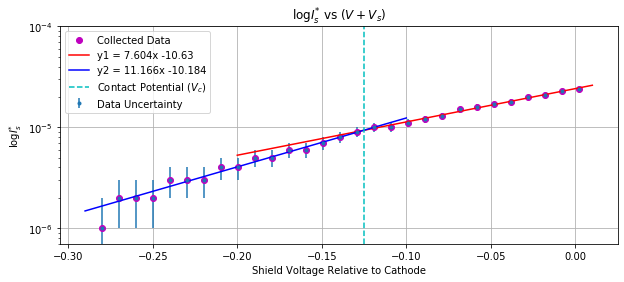

In [18]:
shieldErrorArray = np.array([shieldError]*len(newXAxis)) # creating an array of appropriate 

def chiTest(observed,expected,error): # Create a funciton to calculate the reduced chi squared value for a given line with the data
    chiSq = np.sum(((observed-expected)/error)**2)
    nu = len(observed)-2
    return chiSq/nu

def createTwoLines(point,x,y,graph=False): # generates two lines fitting the data at a given interval (point) that splits the data
    x1 = x[:point]
    y1 = np.log(y[:point])
    A1 = np.vstack([x1,np.ones(len(x1))]).T
    m1,c1 = np.linalg.lstsq(A1,y1,rcond=None)[0]

    x2 = x[point:]
    y2 = np.log(y[point:])
    A2 = np.vstack([x2,np.ones(len(x2))]).T
    m2,c2 = np.linalg.lstsq(A2,y2,rcond=None)[0]
    
    l1 = np.linspace(0.01,-0.2,100)
    l2 = np.linspace(-0.1,-0.29,100)
    
    
    if graph: #plots the data if needed and prints the slopes of the fitted lines
        popt1, pcov1 = curve_fit(semiLogLine, newXAxis[:point], newYAxis[:point], p0=[m1,c1],sigma = shieldErrorArray[:point], absolute_sigma=True)
        popt2, pcov2 = curve_fit(semiLogLine, newXAxis[point:], newYAxis[point:], p0=[m2,c2],sigma = shieldErrorArray[point:], absolute_sigma=True)
        plt.plot(l1,semiLogLine(l1,*popt1),'r',label=f'y1 = {round(popt1[0],3)}x {round(popt1[1],3)}')
        plt.plot(l2,semiLogLine(l2,*popt2),'b',label=f'y2 = {round(popt2[0],3)}x {round(popt2[1],3)}')
        print(f'Line 1: m = {round(popt1[0],3)} +/- {round(np.sqrt(pcov1[0,0]),3)} ') # print slopes and their uncertainties
        print(f'Line 2: m = {popt2[0]} +/- {round(np.sqrt(pcov2[0,0]),3)} ')
 
    return (semiLogLine(x1,m1,c1),semiLogLine(x2,m2,c2))

def findTheLine(xs,ys,errors): # loops over all the possible lines and calculates the sum of reduced chi squared values
    someList = []              # then determines the one with the best fit and plots the corresponding fits
    for i in range(len(xs)):
        exp1,exp2 = createTwoLines(i,xs,ys)
        chiSum = chiTest(ys[:i],exp1,errors)+chiTest(ys[i:],exp2,errors)
        someList.append(1-np.abs(chiSum)) # check this 
    minRedChi = someList.index(max(someList))
    createTwoLines(minRedChi,xs,ys,graph=True)


def findIntersection(m1,c1,m2,c2): #finds the intersection point of the two lines of best fit using matrix maths
    A = np.array([[m1,1],[m2,1]])
    B = np.array([[c1],[c2]])
    sol = np.linalg.solve(A,B)
    return sol
    
plt.figure(1,figsize=(10,4)) # Plots the graph as a whole
plt.semilogy(newXAxis,newYAxis,'mo',label='Collected Data')
plt.title(r'$\log{I_{s}^{*}}$ vs ($V+V_{s}$)')
plt.xlabel('Shield Voltage Relative to Cathode')
plt.ylabel(r'$\log{I_{s}^{*}}$')
plt.errorbar(newXAxis,newYAxis,yerr=shieldError,fmt='.',label='Data Uncertainty') # Error bars
plt.grid(True)
findTheLine(newXAxis,newYAxis,shieldError) # Finding and fitting the corrected lines of best fit to the graph
plt.ylim(7e-7,1e-4)
plt.axvline(x=findIntersection(-7.604,-10.630,-11.166,-10.184)[0],color='c',label=r'Contact Potential ($V_c$)', linestyle='--') # identifying contact potential
plt.legend();
plt.savefig('mainGraph',format='eps')


In [19]:
findIntersection(-7.604,-10.630,-11.166,-10.184) # the x coordinate is the contact potential



array([[ -0.12521056],
       [-11.58210107]])

In [20]:
x1 = newXAxis[:13]
y1 = np.log(newYAxis[:13])
A1 = np.vstack([x1,np.ones(len(x1))]).T
m1,c1 = np.linalg.lstsq(A1,y1,rcond=None)[0]

x2 = newXAxis[13:]
y2 = np.log(newYAxis[13:])
A2 = np.vstack([x2,np.ones(len(x2))]).T
m2,c2 = np.linalg.lstsq(A2,y2,rcond=None)[0]

m1,m2

(7.768188128683587, 12.233786869254779)

In [21]:
popt1, pcov1 = curve_fit(semiLogLine, newXAxis[:13], newYAxis[:13], p0=[m1,c1],sigma = shieldErrorArray[:13], absolute_sigma=True)
popt2, pcov2 = curve_fit(semiLogLine, newXAxis[13:], newYAxis[13:], p0=[m2,c2],sigma = shieldErrorArray[13:], absolute_sigma=True)

print(f' dm1 = {np.sqrt(pcov1[0,0])} \n dc1 = {np.sqrt(pcov1[1,1])} \n dm2 = {np.sqrt(pcov2[0,0])} \n dc2 = {np.sqrt(pcov2[1,1])}')

 dm1 = 0.4787625736338099 
 dc1 = 0.024531846394515354 
 dm2 = 1.443828714592837 
 dc2 = 0.24280809304448978


In [22]:
# Intersection Error

def intersectionErr(x,dm1,dm2,dc1,dc2):
    part1 = (dm1**2)*(x**2)
    part2 = (dm2**2)*((-x)**2)
    part3 = (dc1**2)
    part4 = (dc2**2)
    return np.sqrt(part1+part2+part3+part4)

np.mean(intersectionErr(newXAxis[13],0.479,1.444,0.025, 0.243))    


0.3134495415363851

In [23]:
def findIntersection(m1,c1,m2,c2): #finds the intersection point of the two lines of best fit 
    A = np.array([[m1,1],[m2,1]])
    B = np.array([[c1],[c2]])
    
    sol = np.linalg.solve(A,B)
    print(f'Point of intersection is (x,y) = ({sol[0]},{sol[1]})')

findIntersection(-7.604,-10.630,-11.166,-10.184)

def fullVoltErr(v,vs,vc,vb,dvs,dvc,dvb):
    part1 = dvs**2
    part2 = (-1/(2*np.sqrt(v-vs+vc+vb)))**2
    part3 = dvc**2
    part4 = (1/(2*np.sqrt(v-vs+vc+vb)))**2
    part5 = dvb**2
    part6 = (1/(2*np.sqrt(v-vs+vc+vb)))
    return np.sqrt(part1*part2 + part3*part4 + part5*part6)

correctedElectronMomentumErr = fullVoltErr(uncooled1_Va,(uncooled1_Vs/1000),0.125,0.134,0.0001,0.098,0.02)

Point of intersection is (x,y) = ([-0.12521056],[-11.58210107])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


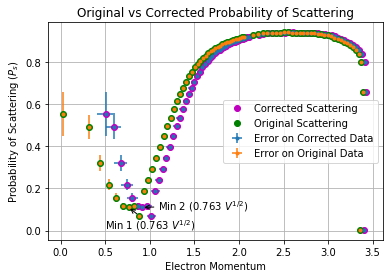

In [24]:
# Plotting the corrected probability of scattering against the original

realPotential = np.sqrt(np.abs(uncooled1_Va - (uncooled1_Vs/1000)+0.125+0.134)) # accounting for contact potential and energy distribution


plt.plot(realPotential,np.abs(scatterProb),'mo', label = 'Corrected Scattering')
plt.plot(electronMomentum,np.abs(scatterProb),'go', label = 'Original Scattering')
plt.errorbar(realPotential,np.abs(scatterProb), xerr =correctedElectronMomentumErr, yerr = scatterProbErr, fmt = '.',label='Error on Corrected Data')
plt.errorbar(electronMomentum,np.abs(scatterProb),xerr= simpleElectronMomentumErr, yerr = scatterProbErr, fmt = '.',label='Error on Original Data')
plt.xlabel(r'Electron Momentum')
plt.ylabel(r'Probability of Scattering ($P_s$)')
plt.title('Original vs Corrected Probability of Scattering')
plt.grid(True)
plt.legend()

plt.annotate(r'Min 1 (0.763 $V^{1/2}$)', (electronMomentum[6],scatterProb[6]),(0.5,0.01),arrowprops={'arrowstyle':'->'})
plt.annotate(r'Min 2 (0.763 $V^{1/2}$)', (realPotential[6],scatterProb[6]),(1.09,0.1),arrowprops={'arrowstyle':'->'});
plt.savefig('correctedScatterProbFinal',format='eps');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


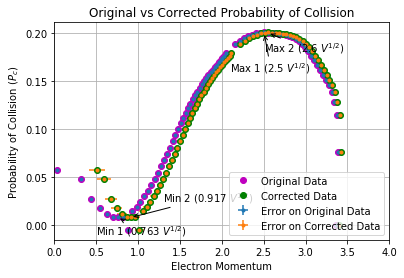

In [25]:
# Plotting the corrected probability of collision against the original

plt.plot(electronMomentum,collisionProb,'mo',label='Original Data')
plt.plot(realPotential,collisionProb,'go',label='Corrected Data')
plt.errorbar(electronMomentum,collisionProb, xerr = simpleElectronMomentumErr, yerr = collisionProbError, fmt = '.',label='Error on Original Data')
plt.errorbar(realPotential,collisionProb, xerr = correctedElectronMomentumErr, yerr = collisionProbError, fmt = '.',label='Error on Corrected Data')
plt.xlim([0,4])
plt.grid(True)
plt.xlabel('Electron Momentum')
plt.ylabel(r'Probability of Collision ($P_c$)')
plt.title('Original vs Corrected Probability of Collision')
plt.annotate(r'Min 1 (0.763 $V^{1/2}$)', (electronMomentum[6],collisionProb[6]),(0.5,-0.01),arrowprops={'arrowstyle':'->'})
plt.annotate(r'Max 1 (2.5 $V^{1/2}$)', (electronMomentum[-26],collisionProb[-27]),(2.1,0.16),arrowprops={'arrowstyle':'->'})
plt.annotate(r'Min 2 (0.917 $V^{1/2}$)', (realPotential[6],collisionProb[6]),(1.3,0.025),arrowprops={'arrowstyle':'->'})
plt.annotate(r'Max 2 (2.6 $V^{1/2}$)', (realPotential[-26],collisionProb[-25]),(2.5,0.18),arrowprops={'arrowstyle':'->'})
plt.legend();
plt.savefig('correctedCollisionProbFinal',format='eps')


In [26]:
realPotential[6], correctedElectronMomentumErr[6]

(0.9167878707749137, 0.05545077911452706)